In [1]:
# Import Libraries, Set Plotting Options

import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt
import fiona
import seaborn as sns
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
from rasterio.mask import mask
from scipy.stats import *
%matplotlib inline
sns.set(color_codes=True)

In [2]:
dem_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_june5_2017_DEM.tif')
dem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 16384,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 397068.0,
       0.0, -1.0, 7624870.0),
 'width': 20480}

In [3]:
snow_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/clpx_2013_102_snow_on_dem.tif')
snow_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 5562,
 'nodata': -9999.0,
 'transform': Affine(2.0, 0.0, 398554.4803161621,
       0.0, -2.0, 7621529.570800781),
 'width': 9462}

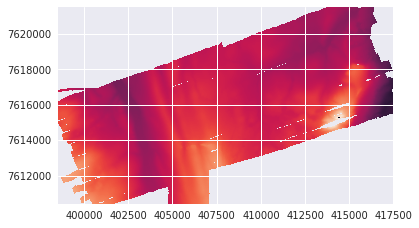

In [4]:
show(snow_src)

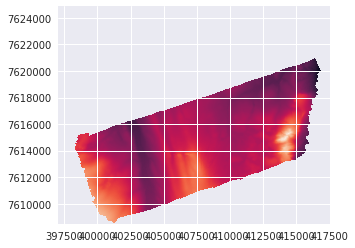

In [5]:
show(dem_src)

In [6]:
arr = snow_src.read()
newarr = np.empty(shape=(arr.shape[0],  # same number of bands
                         round(arr.shape[1] * 2), # 200% resolution
                         round(arr.shape[2] * 2)))

# adjust the new affine transform to the 200% smaller cell size
aff = snow_src.transform
newaff = rasterio.Affine(aff.a / 2, aff.b, aff.c,
                aff.d, aff.e / 2, aff.f)

reproject(
    arr, newarr,
    src_transform = aff,
    dst_transform = newaff,
    src_crs = snow_src.crs,
    dst_crs = snow_src.crs,
    resample = Resampling.bilinear)

In [7]:
newarr[newarr == -9999] = np.nan
newarr = newarr.astype('float32')
out_meta = snow_src.meta.copy()
out_meta.update({'transform': newaff})
out_meta.update({'height': newarr[0].shape[0]})
out_meta.update({'width': newarr[0].shape[1]})
out_meta.update({'nodata': np.nan})
out_meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11124,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 398554.4803161621,
       0.0, -1.0, 7621529.570800781),
 'width': 18924}

In [8]:
with rasterio.open("/home/cparr/surfaces/level_1_surfaces/clpx/clpx_102_2013_1x1.tif",
                   "w", **out_meta) as dest:
    dest.write(newarr[0],1)

In [9]:
snow_src = rasterio.open('/home/cparr/surfaces/level_1_surfaces/clpx/clpx_102_2013_1x1.tif')
snow_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11124,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 398554.4803161621,
       0.0, -1.0, 7621529.570800781),
 'width': 18924}

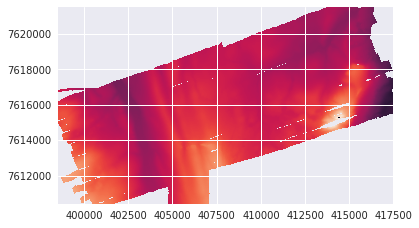

In [10]:
show(snow_src)

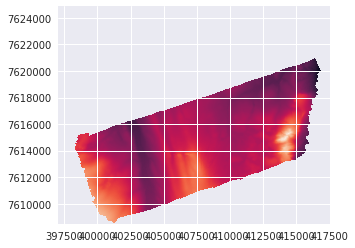

In [11]:
show(dem_src)

In [12]:
with fiona.open("/home/cparr/surfaces/level_1_surfaces/clpx/clipper_2013.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

out_image, out_transform = mask(dem_src, geoms, crop=True)
out_meta = dem_src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Write the cropped version out to a new raster

with rasterio.open("/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_dem_crop_to_2013.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [13]:
dem_crop = rasterio.open("/home/cparr/surfaces/level_1_surfaces/clpx/bare_earth/clpx_dem_crop_to_2013.tif")
dem_crop.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11125,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 398554.0,
       0.0, -1.0, 7621530.0),
 'width': 18925}

In [14]:
snow_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11124,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 398554.4803161621,
       0.0, -1.0, 7621529.570800781),
 'width': 18924}

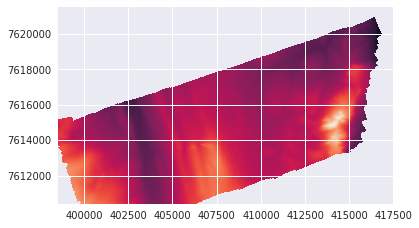

In [15]:
show(dem_crop)

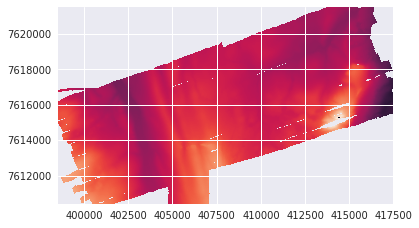

In [16]:
show(snow_src)

In [17]:
dem_crop.bounds

BoundingBox(left=398554.0, bottom=7610405.0, right=417479.0, top=7621530.0)

In [18]:
snow_src.bounds

BoundingBox(left=398554.4803161621, bottom=7610405.570800781, right=417478.4803161621, top=7621529.570800781)

In [19]:
dem_for_diff = dem_crop.read(1)[1:,:-1]
dem_for_diff.shape

(11124, 18924)

/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/cparr/miniconda3/envs/raster_IO_pd/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


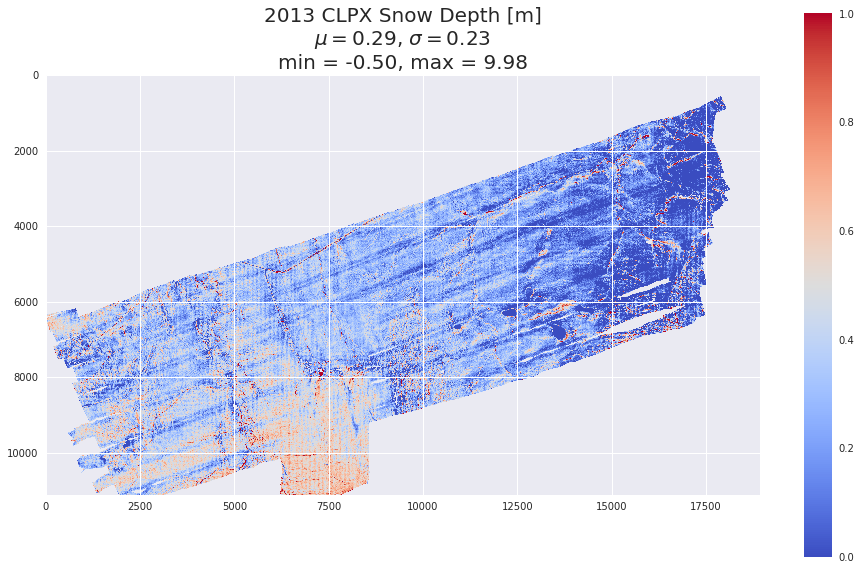

In [20]:
depth = snow_src.read(1) - dem_for_diff
depth[depth < -0.5] = np.nan
depth[depth > 10] = np.nan

mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)
im = ax.imshow(depth,vmin=0, vmax=1, cmap ='coolwarm')
ax.set_title("2013 CLPX Snow Depth [m]" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

In [21]:
out_meta = dem_crop.meta.copy()
out_meta.update({"height": depth.shape[0],
                 "width": depth.shape[1]})
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_102_2013_dDEM_no_offset.tif",
                   "w", **out_meta) as dest:
    dest.write(depth,1)

In [22]:
ddem_src = rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_102_2013_dDEM_no_offset.tif")
ddem_src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11124,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 398554.0,
       0.0, -1.0, 7621530.0),
 'width': 18924}

In [23]:
# This code block reads in the MagnaProbe shapefile and then compares the depth of the dDEM and the probe 
# measuremnt at each probe location.

with fiona.open("/home/cparr/probes/clpx/imnav_04132013_utm.shp", "r") as shapefile:
    features = [feature for feature in shapefile]
    
errors = []
sfm = []
probe = []

for feature in features:
    sfm_depth = [val for val in ddem_src.sample([feature['geometry']['coordinates']])][0][0]
    probe_depth = feature['properties']['Depth_m']
    probe_sfm_diff = probe_depth - sfm_depth
    errors.append(probe_sfm_diff)
    sfm.append(sfm_depth)
    probe.append(probe_depth)
    
sfm = np.array(sfm)
probe = np.array(probe)
errors = np.array(errors)

For each MagnaProbe measurement I subtracted the dDEM measurment at the same location. Let's take a look at how the two measurement types compare.

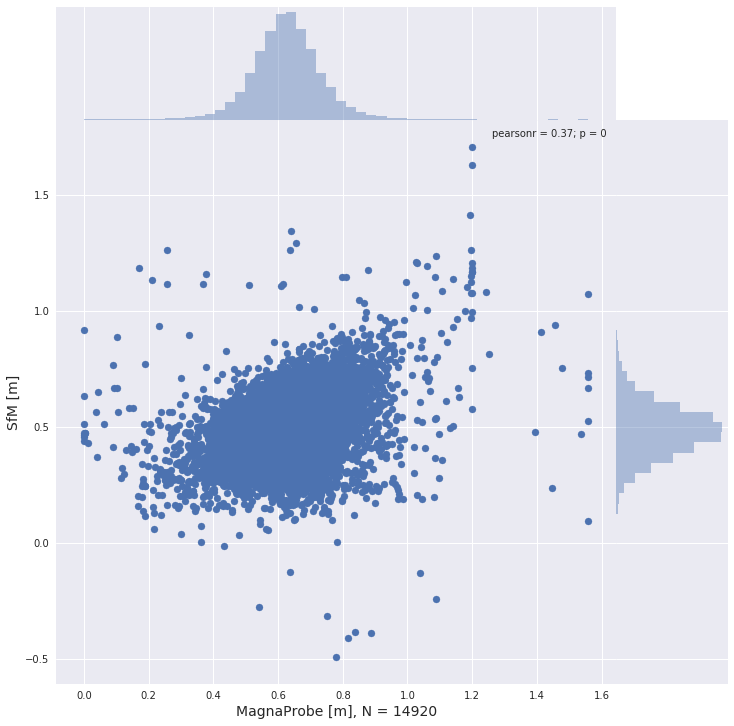

In [24]:
ax = (sns.jointplot(x=probe, y=sfm, kind="scatter", size=10, space=0)
        .set_axis_labels("MagnaProbe [m], N = " + str(probe.size), "SfM [m]", fontsize=14))

The two samples correlate pretty well and the distributions look similar. Let's check the errors.

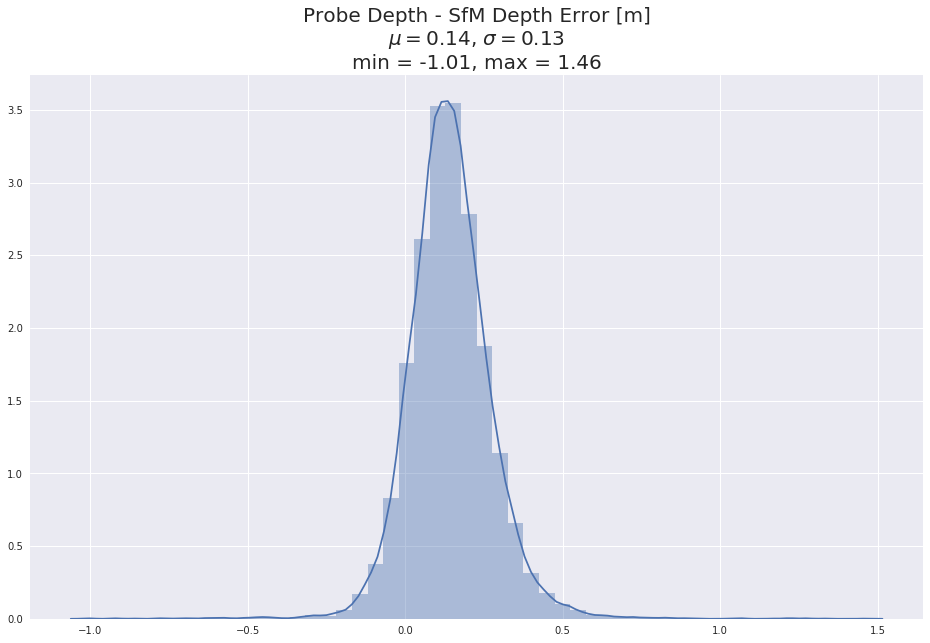

In [25]:
errors = errors[~np.isnan(errors)]

mu = np.nanmean(errors)
sigma = np.nanstd(errors)
dmin = np.nanmin(errors)
dmax = np.nanmax(errors)

plt.figure(figsize=(16,10))
ax = sns.distplot(errors, hist=True)
ax.set_title('Probe Depth - SfM Depth Error [m]' +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax), fontsize=20)

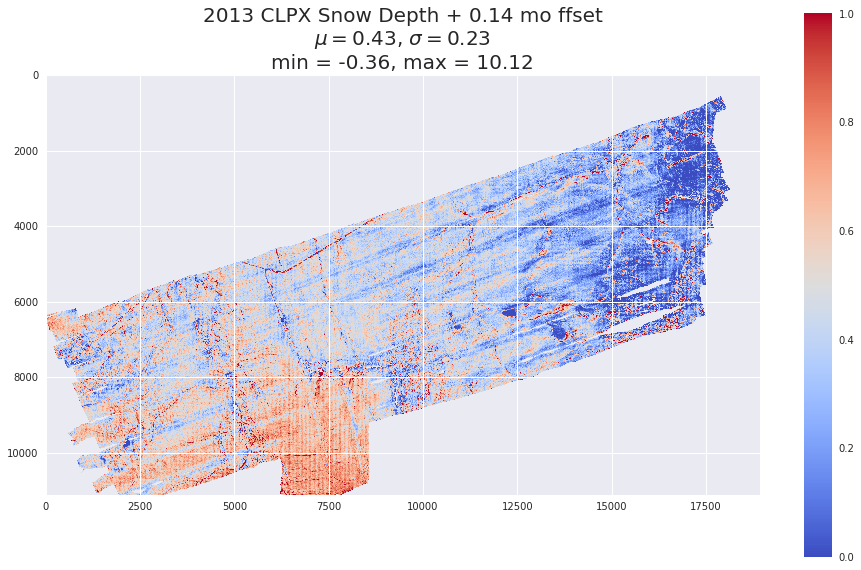

In [26]:
depth = ddem_src.read(1) + 0.14
mu = np.nanmean(depth)
sigma = np.nanstd(depth)
dmin = np.nanmin(depth)
dmax = np.nanmax(depth)

fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(111)

im = ax.imshow(depth,vmin=0, vmax=1, cmap ='coolwarm')

ax.set_title("2013 CLPX Snow Depth + 0.14 mo ffset" +'\n'+
             "$\mu=%.2f$, $\sigma=%.2f$"  %(mu,sigma)  +'\n'+
             "min = %.2f, max = %.2f" %(dmin,dmax),fontsize=20)
fig.colorbar(im)

In [27]:
with rasterio.open("/home/cparr/surfaces/depth_ddems/clpx/clpx_096_2013_dDEM_014m_offset.tif",
                   "w", **ddem_src.meta) as dest:
    dest.write(depth,1)